__Поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка__

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import itertools
import matplotlib.pyplot as plt

%matplotlib inline

Ссылка на google drive: https://drive.google.com/file/d/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91' -O churn_data.csv

--2023-07-18 17:54:34--  https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91
Resolving drive.google.com (drive.google.com)... 142.250.180.206
Connecting to drive.google.com (drive.google.com)|142.250.180.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a6ma5b5t0s2orhs99db8ip7tree4vtnh/1689695625000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download&uuid=47bb54b3-96b3-4282-b3ab-ad45efbac670 [following]
--2023-07-18 17:54:35--  https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a6ma5b5t0s2orhs99db8ip7tree4vtnh/1689695625000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download&uuid=47bb54b3-96b3-4282-b3ab-ad45efbac670
Resolving doc-14-c0-docs.googleusercontent.com (doc-14-c0-docs.googleusercontent.com)... 142.250.180.225
Connecting to doc-14-c0-docs.googleuserc

In [3]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [4]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Построим модель, и сразу же будем работать с использованием sklearn pipeline

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [6]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
    
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [8]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Теперь нам нужно под каждый признак создать трансформер и объединить их в список.

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [10]:
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:
    - логистическая регрессия
    - дерево решений
    - бустинги

#### 1. LogisticRegression

In [11]:
pipeline_lr = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=7575)),
])


# обучим пайплайн на всем тренировочном датасете
pipeline_lr.fit(X_train, y_train)

preds = pipeline_lr.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.2895219552169298, F-Score=0.510, Precision=0.462, Recall=0.568


In [12]:
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC


In [13]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.7720774921330664

In [14]:
row_lr = {
    'model': type(pipeline_lr['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}

metrics_df = pd.concat([metrics_df, pd.DataFrame(row_lr, index=[0])], ignore_index=True)
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,LogisticRegression,0.289522,0.5097,0.4624,0.56778,0.772077


Отрисуем матрицу ошибок

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


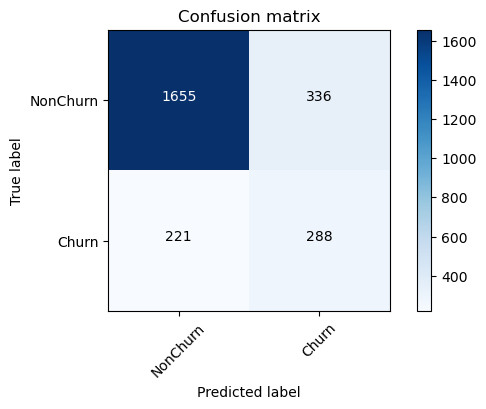

In [17]:
font = {'size' : 10}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### 2. DecisionTreeClassifier

In [18]:
pipeline_dt = Pipeline([
    ('features', feats),
    ('classifier', DecisionTreeClassifier(max_depth=5,
                                          random_state=7575)),
])


# обучим пайплайн на всем тренировочном датасете
pipeline_dt.fit(X_train, y_train)

preds = pipeline_dt.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.4979757085020243, F-Score=0.613, Precision=0.701, Recall=0.544


In [19]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8444557483133828

In [20]:
row_dt = {
    'model': type(pipeline_dt['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}

metrics_df = pd.concat([metrics_df, pd.DataFrame(row_dt, index=[0])], ignore_index=True)
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,LogisticRegression,0.289522,0.509700,0.462400,0.567780,0.772077
1,DecisionTreeClassifier,0.497976,0.612832,0.701266,0.544204,0.844456


Confusion matrix, without normalization
[[1923   68]
 [ 281  228]]


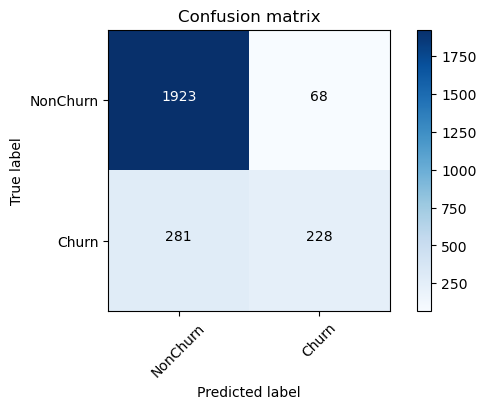

In [21]:
font = {'size' : 10}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### 3. XGBClassifier

In [22]:
pipeline_xgb = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state=7575)),
])


# обучим пайплайн на всем тренировочном датасете
pipeline_xgb.fit(X_train, y_train)

preds = pipeline_xgb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.3733177185058594, F-Score=0.626, Precision=0.619, Recall=0.633


In [23]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8609212971140268

In [24]:
row_xgb = {
    'model': type(pipeline_xgb['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}

metrics_df = pd.concat([metrics_df, pd.DataFrame(row_xgb, index=[0])], ignore_index=True)
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,LogisticRegression,0.289522,0.509700,0.462400,0.567780,0.772077
1,DecisionTreeClassifier,0.497976,0.612832,0.701266,0.544204,0.844456
2,XGBClassifier,0.373318,0.625850,0.619231,0.632613,0.860921


Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


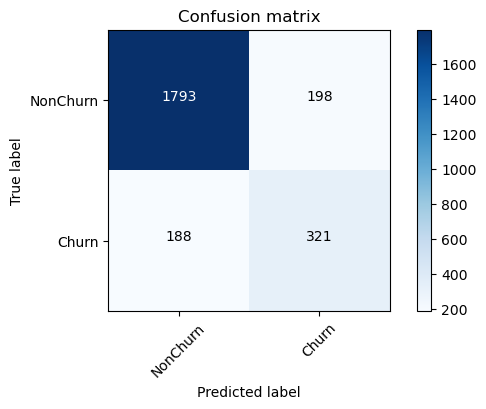

In [25]:
font = {'size' : 10}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### 4. CatBoostClassifier

In [26]:
pipeline_ctb = Pipeline([
    ('features', feats),
    ('classifier', ctb.CatBoostClassifier(verbose=False, random_state=7575)),
])


# обучим пайплайн на всем тренировочном датасете
pipeline_ctb.fit(X_train, y_train)

preds = pipeline_ctb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.3995483372475593, F-Score=0.644, Precision=0.669, Recall=0.621


In [27]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8755046037226458

In [28]:
row_ctb = {
    'model': type(pipeline_ctb['classifier']).__name__,
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}

metrics_df = pd.concat([metrics_df, pd.DataFrame(row_ctb, index=[0])], ignore_index=True)
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,LogisticRegression,0.289522,0.509700,0.462400,0.567780,0.772077
1,DecisionTreeClassifier,0.497976,0.612832,0.701266,0.544204,0.844456
2,XGBClassifier,0.373318,0.625850,0.619231,0.632613,0.860921
3,CatBoostClassifier,0.399548,0.644241,0.669492,0.620825,0.875505


Confusion matrix, without normalization
[[1835  156]
 [ 194  315]]


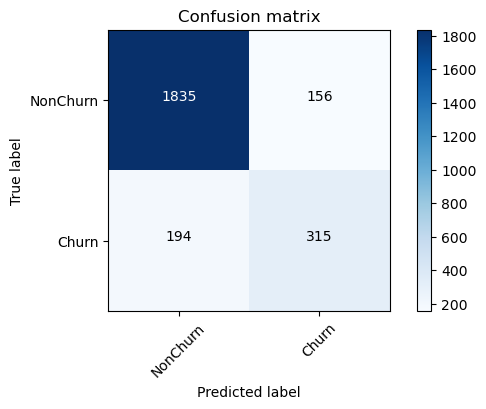

In [29]:
font = {'size' : 10}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### 2. Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)

In [30]:
metrics_df.sort_values('F-Score')

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,LogisticRegression,0.289522,0.509700,0.462400,0.567780,0.772077
1,DecisionTreeClassifier,0.497976,0.612832,0.701266,0.544204,0.844456
2,XGBClassifier,0.373318,0.625850,0.619231,0.632613,0.860921
3,CatBoostClassifier,0.399548,0.644241,0.669492,0.620825,0.875505


### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:
    - 1 доллар на удержание
    - 2 доллара - с каждого правильно классифицированного (True Positive)

In [31]:
preds = pipeline_ctb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

In [32]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


add_sum = TP * 2 - np.sum(cnf_matrix[:, 1]) * 1
print('дополнительный доход: ', add_sum)

дополнительный доход:  159


### 4. *Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [33]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

In [54]:
def objective(space):
    
    ctb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': 7575,
        'n_estimators': int(space['n_estimators']),
        'verbose': False
        
    }
    
    #class_weight = {0: 1, 1: 4}
    pipeline_ctb = Pipeline([
    ('features', feats),
    ('classifier', ctb.CatBoostClassifier(**ctb_params)),
])
    pipeline_ctb.fit(X_train, y_train)
    preds = pipeline_ctb.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    
    return{'loss':-fscore[ix], 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('x_max_depth', 3, 10, 1),
    'learning_rate': hp.uniform ('x_learning_rate', 0.01, 0.4),
    'subsample': hp.uniform ('x_subsample', 0.1, 1.),
    'random_state': 7575,
    'n_estimators': hp.quniform ('x_n_estimators', 50, 300, 50),
    'verbose': False,
    'boosting_type':"Plain"
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials
                   
            )

print("The best params: ", best_params)

100%|██████████| 30/30 [00:14<00:00,  2.14trial/s, best loss: -0.6568109820485745]
The best params:  {'x_learning_rate': 0.0835311745782883, 'x_max_depth': 5.0, 'x_n_estimators': 100.0, 'x_subsample': 0.1068687607161268}


In [55]:
best_params

{'x_learning_rate': 0.0835311745782883,
 'x_max_depth': 5.0,
 'x_n_estimators': 100.0,
 'x_subsample': 0.1068687607161268}

In [56]:
pipeline_ctb_tuned = Pipeline([
    ('features', feats),
    ('classifier', ctb.CatBoostClassifier(learning_rate = 0.0835311745782883,
                                          max_depth = 5,
                                          n_estimators = 100,
                                          random_state = 7575,
                                          subsample = 0.1068687607161268,
                                          boosting_type="Plain",
                                          #one_hot_max_size=20,
                                          verbose=False
                                      ))
     ])


# обучим пайплайн на всем тренировочном датасете
pipeline_ctb_tuned.fit(X_train, y_train)

preds = pipeline_ctb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')                                                                        

Best Threshold=0.4004244883525881, F-Score=0.657, Precision=0.710, Recall=0.611


5. *Еще раз провести оценку экономической эффективности

In [57]:
preds = pipeline_ctb_tuned.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

In [58]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

add_sum = TP * 2 - np.sum(cnf_matrix[:, 1]) * 1
print('дополнительный доход: ', add_sum)

дополнительный доход:  183


Confusion matrix, without normalization
[[1864  127]
 [ 199  310]]


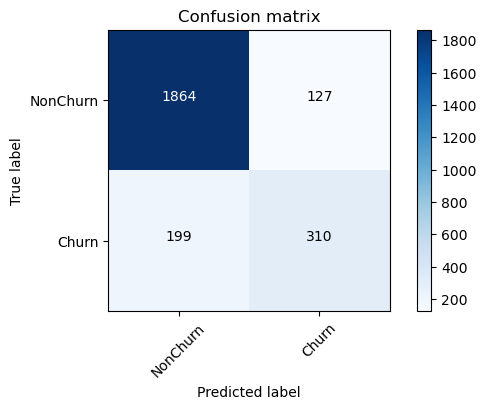

In [59]:
font = {'size' : 10}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()